In [70]:
from langchain_openai import OpenAI
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_ollama.chat_models import ChatOllama
from pydantic import BaseModel, Field
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings
import chromadb
import pandas as pd
from pprint import pprint
from IPython.display import Image, display
import requests
from langgraph.graph import StateGraph, START, END

In [209]:
llm = ChatGroq(temperature=0, model_name= "llama-3.1-70b-versatile")
sql_llm = ChatGroq(model_name= "llama-3.1-70b-versatile")    

# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.0)
# sql_llm = ChatOpenAI(model="gpt-4-turbo")

### 올라마 도커 기동
db_path = "./db/chroma_db_02"
vectorstore = Chroma(collection_name="collection_01", persist_directory=db_path, embedding_function=OllamaEmbeddings(base_url="http://localhost:11434", model="bge-m3:latest"))

In [210]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeDocuments)
retrieval_grader = grade_prompt | structured_llm_grader

prompt = ChatPromptTemplate.from_messages([
    ("human", 
    """You are a smart AI assistant. 
    Use the following pieces of retrieved context to answer the question. 
    Generate detailed answer including specified numbers, fomulas in the point of technical specifications. 
    If you don't know the answer, just say that you don't know. 
    Question: {question} 
    Context: {context} 
    Answer:"""),
    ])

rag_chain = prompt | llm | StrOutputParser()

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)
hallucination_grader = hallucination_prompt | structured_llm_grader

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeAnswer)
answer_grader = answer_prompt | structured_llm_grader


from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [211]:
from typing import List, Annotated
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages


class GraphState(MessagesState):
    """
    Represents the state of our graph.

    Attributes:
        connection: web connection
        question: question
        generation: LLM generation
        documents: list of documents
    """
    connection: bool = False
    question: str
    generation: str   
    documents: List[str]

In [217]:
from langchain.schema import Document
from langchain_core.messages import RemoveMessage
from langchain_core.messages import AIMessage, HumanMessage

### Node

def filter_messages(state: GraphState):
    # print(f">>> state: {state}")
    # Delete all but the 2 most recent messages
    print(f">>> 필터 전 리스트 길이 : {len(state["messages"])}")
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-4]]
    print(f">>> 필터 후 리스트 길이 : {len(state["messages"]) - len(delete_messages)}")
    return {"messages": delete_messages}

def generate(state):
    # print(f">>> state: {state}")
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    try:
        print(f"Count of Retrieved Docs: {len(documents)}")
        filtered_docs = []
        for d in documents:
            score = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                continue
        return {"documents": filtered_docs, "question": question}
    except Exception as e:
        print(f"Count of Retrieved Docs: {len(documents)}")
        print(e)


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_connection(state):
    print("---WEB CONNECTION---")
    res = check_internet(state)
    return {"connection": res}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    print(f">>> state: {state}")
    question = state["messages"][0].content

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Edges ###

def check_internet(state):
    """Check internet connection by pinging a website."""
    
    print("---CHECK INTERNET CONNECTION---")
    # question = state["question"]
    try:
        response = requests.get("https://www.google.com", timeout=2)
        # If the request is successful, we assume internet is ON
        if response.status_code == 200:
            # print("Internet is ON")
            return "ON"
    except requests.ConnectionError:
        # If there is a connection error, we assume internet is OFF
        # print("Internet is OFF")
        return "OFF"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION(Useful): GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION(Not Useful): GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION(Not Supported): GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

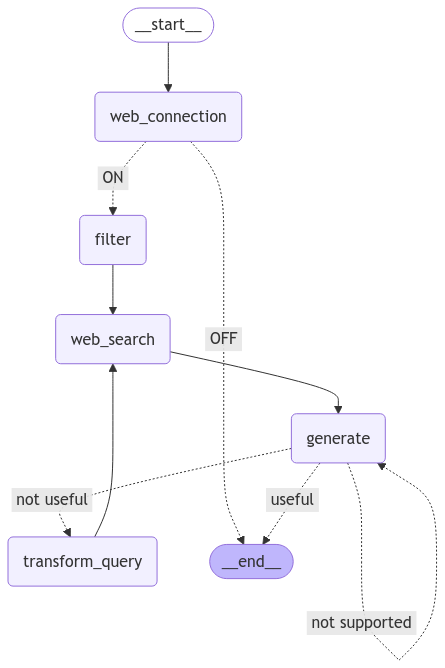

In [218]:
def web_builder(state):
    web_builder = StateGraph(state)
    web_builder.add_node("web_connection", web_connection)
    web_builder.add_node("filter", filter_messages)
    web_builder.add_node("web_search", web_search)
    web_builder.add_node("generate", generate)
    web_builder.add_node("transform_query", transform_query)

    web_builder.add_edge(START, "web_connection")
    web_builder.add_conditional_edges(
        "web_connection",
        check_internet,
        {
            "ON": "filter",
            "OFF": END,
        },
    )
    web_builder.add_edge("filter", "web_search")
    web_builder.add_edge("web_search", "generate")
    web_builder.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "not supported": "generate",
            "useful": END,
            "not useful": "transform_query",
        },
    )
    web_builder.add_edge("transform_query", "web_search")
    return web_builder.compile()

graph = web_builder(state = GraphState)
display(Image(graph.get_graph().draw_mermaid_png()))

In [229]:
from langchain_core.messages import AIMessage, HumanMessage
messages = []

# question = "what is the capital of south korea?"
# messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
# output = graph.invoke({'messages': messages})
# print(f">>> output: {output}")
# messages.append(AIMessage(output["generation"], name="Kim", id=str(len(messages))))
# print(f">>> 후 messages: {messages}")

question = "what is the capital of japan?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages})
print(f">>> output: {output}")
messages.append(AIMessage(output["generation"], name="Kim", id=str(len(messages))))
print(f">>> 후 messages: {messages}")


question = "what is the capital of china?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'question': messages})
print(f">>> output: {output}")
messages.append(AIMessage(output["generation"], name="Kim", id=str(len(messages))))
print(f">>> 후 messages: {messages}")

# question = "what is the distance between two capitals?"
# messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
# output = graph.invoke({'question': messages})
# print(f">>> output: {output}")
# messages.append(AIMessage(output["generation"], name="Kim", id=str(len(messages))))
# print(f">>> 후 messages: {messages}")

---WEB CONNECTION---
---CHECK INTERNET CONNECTION---
---CHECK INTERNET CONNECTION---
>>> 필터 전 리스트 길이 : 1
>>> 필터 후 리스트 길이 : 1
---WEB SEARCH---
>>> state: {'messages': [HumanMessage(content='what is the capital of japan?', additional_kwargs={}, response_metadata={}, name='Kim', id='0')], 'connection': 'ON'}
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION(Useful): GENERATION ADDRESSES QUESTION---
>>> output: {'messages': [HumanMessage(content='what is the capital of japan?', additional_kwargs={}, response_metadata={}, name='Kim', id='0')], 'connection': 'ON', 'question': 'what is the capital of japan?', 'generation': 'The capital of Japan is Tokyo.', 'documents': Document(metadata={}, page_content='Tokyo, the capital of Japan, is situated at the head of Tokyo Bay on the Pacific coast of central Honshu. First developed into a city during the Tokugawa period (1603-1867), when the site was known as E

IndexError: list index out of range

In [228]:
messages

[HumanMessage(content='what is the capital of japan?', additional_kwargs={}, response_metadata={}, name='Kim', id='0'),
 AIMessage(content='The capital of Japan is Tokyo.', additional_kwargs={}, response_metadata={}, name='Kim', id='1')]